In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import re
import json
import csv
import threading
import os
import pickle

import datetime

import yfinance as yf
import yahoofinancials


In [2]:
def min_max_date(df):
    """
    Get the min and max date of the ticker being mentioned in our WSB dataset
    """
    min_date = df.sort_values('datetime').iloc[0]["datetime"].date()
    max_date = df.sort_values('datetime', ascending= False).iloc[0]["datetime"].date()
    return(min_date, max_date)

def explode_action_column(df):
    """
    Explodes columns of
    dict(puts: [., ., .,]
         calls: [., ., .,]
         sell: [., ., .,]
         buy: [., ., .,])
         
    into four columns ...
    |puts|calls|sell|buy|
    """
    return pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)

def date_from_datetime(df):
    """
    Make datetime to date
    """
    df_copy = df.copy()
    df_copy["Date"] = df_copy["datetime"].dt.date
    return df_copy

def flatten_filter(df, ticker, filter = True):
    """
    Explodes the column of lists of tickers into multiple rows and then filter for ticker
    """
    df_copy = df.copy()
    df_flatten = df_copy.explode('tickers')
    if filter:
        df_flatten = df_flatten[df_flatten['tickers'] == ticker]
    else:
        return df_flatten
    return df_flatten

def indicator_actions(df, ticker):
    """
    Make indicator variables for ticker instead of list of tickers
    """
    df_copy = df.copy()
    df_copy = explode_action_column(df_copy)
    df_copy["puts"] = ((df_copy["puts"].apply(len) != 0) & 
                      (df_copy["puts"].astype('str').str.contains(ticker))).astype(int)
    df_copy["calls"] = ((df_copy["calls"].apply(len) != 0) & 
                       (df_copy["calls"].astype('str').str.contains(ticker))).astype(int)
    df_copy["buy"] = ((df_copy["buy"].apply(len) != 0) & 
                     (df_copy["buy"].astype('str').str.contains(ticker))).astype(int)
    df_copy["sell"] = ((df_copy["sell"].apply(len) != 0) & 
                      (df_copy["sell"].astype('str').str.contains(ticker))).astype(int)
    return df_copy

def plot_actions(df, ticker, min_date, max_date, hide_score = True):
    """
    Plot the aggregate sum of sell, buy, calls ,puts for each day within range for a specific ticker
    """
    df_copy = df.copy()
    
    # Aggregate financial action frequency per day
    if hide_score:
        agg_sell = df_copy[['Date','sell','buy','calls','puts']].groupby('Date').agg('sum')
    else:
        agg_sell = df_copy[['Date','sell','buy','calls','puts','score','ups']].groupby('Date').agg('sum')


    # Filter for range specified
    mask = (agg_sell.index > pd.to_datetime("2018-01-01").date()) & (agg_sell.index <= max_date)

    agg_sell.loc[mask].plot(figsize=(12, 10), linewidth=2.5)
    plt.xlabel("Date", labelpad=15)
    plt.ylabel("Movement Mentions", labelpad=15)
    plt.title("Movement mentions for {0} from {1} to {2}".format(ticker, str(min_date), str(max_date)), y=1.02, fontsize=22);

def plot_stock_vs_wsb(df,ticker, min_date, max_date, stock_col, action_col):
    """
    Plot the a specfic financial action mention in WSB comments vs historical data
    """
    df_copy = df.copy()
    
    # Aggregate financial action frequency per day
    agg_sell = df_copy[['Date','sell','buy','calls','puts','score','ups']].groupby('Date').agg('sum')
    
    
    # Get the minimum date of that ticker mentioned on our WSB comment
    MIN_DATE, MAX_DATE = min_max_date(df)

    # Pull the data from yahoo finance api
    stock_data = yf.download(ticker, start = MIN_DATE, end = MAX_DATE)
    
    # Filter for range specified
    mask = (stock_data.index > np.datetime64(str(min_date))) & (stock_data.index <= np.datetime64(max_date))

    plot_multi(stock_data.loc[mask].join(other = agg_sell)[[stock_col,action_col]], figsize=(10,5))

    plt.xlabel("Date", labelpad=15)
    plt.ylabel("Daily {0} mentions".format(action_col), labelpad=15)
    plt.title("Daily {1} mentions vs {2} from {3} to {4} for {0}".format(ticker, action_col, stock_col, str(min_date), str(max_date)), y=1.02, fontsize=22);

In [3]:
data = pickle.load(open("wsb.pkl", "rb"))


In [4]:
ticker = "TSLA"
tesla_df = date_from_datetime(flatten_filter(data, ticker))


In [5]:
# Get the minimum date of that ticker mentioned on our WSB comment
MIN_DATE, MAX_DATE = min_max_date(tesla_df)

    # Pull the data from yahoo finance api
stock_data = yf.download(ticker, start = MIN_DATE, end = MAX_DATE)


[*********************100%***********************]  1 of 1 completed


In [6]:
tesla_sent = indicator_actions(tesla_df, ticker)


In [7]:
agg_sell = tesla_sent[['Date','sell','buy','calls','puts','score']].groupby('Date').agg('sum')

df = agg_sell.join(stock_data).dropna().reset_index()


In [8]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()


,Date,sell,buy,calls,puts,score,Open,High,Low,Close,Adj Close,Volume
0,2013-04-09,0,1,0,0,1,41.799999,41.830002,40.330002,40.500000,40.500000,1696100.0
1,2013-05-08,0,1,0,0,2,57.500000,58.200001,55.709999,55.790001,55.790001,6769900.0
2,2013-05-09,1,0,0,0,1,70.120003,75.769997,63.689999,69.400002,69.400002,28605000.0
3,2013-05-10,0,2,0,0,3,69.650002,81.000000,69.250000,76.760002,76.760002,25082600.0
4,2013-05-14,1,2,0,0,3,94.220001,97.120003,81.150002,83.239998,83.239998,37163900.0


In [9]:
tesla_df["datetime"].sort_values()

501599    2013-04-09 01:49:54
486147    2013-05-08 23:55:20
364121    2013-05-09 19:32:33
337471    2013-05-10 08:21:14
178835    2013-05-10 17:56:30
                  ...        
1512937   2018-10-31 21:00:42
1796100   2018-10-31 21:52:51
2153338   2018-10-31 21:54:59
1983870   2018-10-31 23:15:16
1606485   2018-10-31 23:57:06
Name: datetime, Length: 12079, dtype: datetime64[ns]

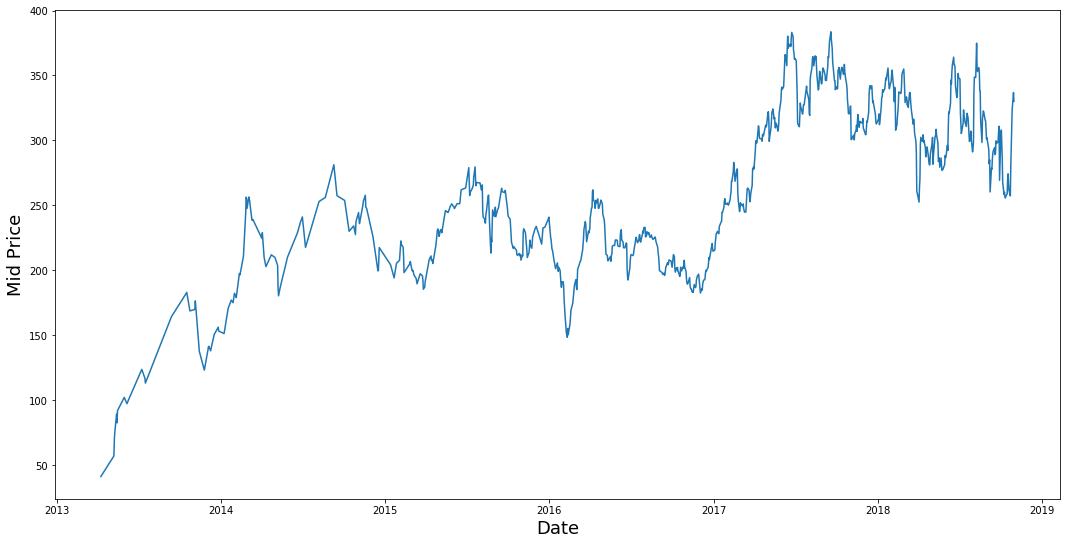

In [10]:
plt.figure(figsize = (18,9))
plt.plot(df["Date"],(df['Low']+df['High'])/2.0)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


In [11]:
# First calculate the mid prices from the highest and lowest
high_prices = np.matrix(df.loc[:,'High'])
low_prices = np.matrix(df.loc[:,'Low'])
mid_prices = (high_prices+low_prices)/2.0


In [12]:
train_data = mid_prices[0,:800]
test_data = mid_prices[0,800:]


In [13]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


In [14]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 10
for di in range(0,100,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])



In [15]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)



In [16]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
test_train_data = train_data.copy()
EMA = 0.0
gamma = 0.1
for ti in range(800):
    EMA = gamma*train_data[0,ti] + (1-gamma)*EMA
    test_train_data[0,ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([test_train_data.T,test_data.reshape(103, 1)],axis=0)

In [17]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[0,pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[0,pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01044


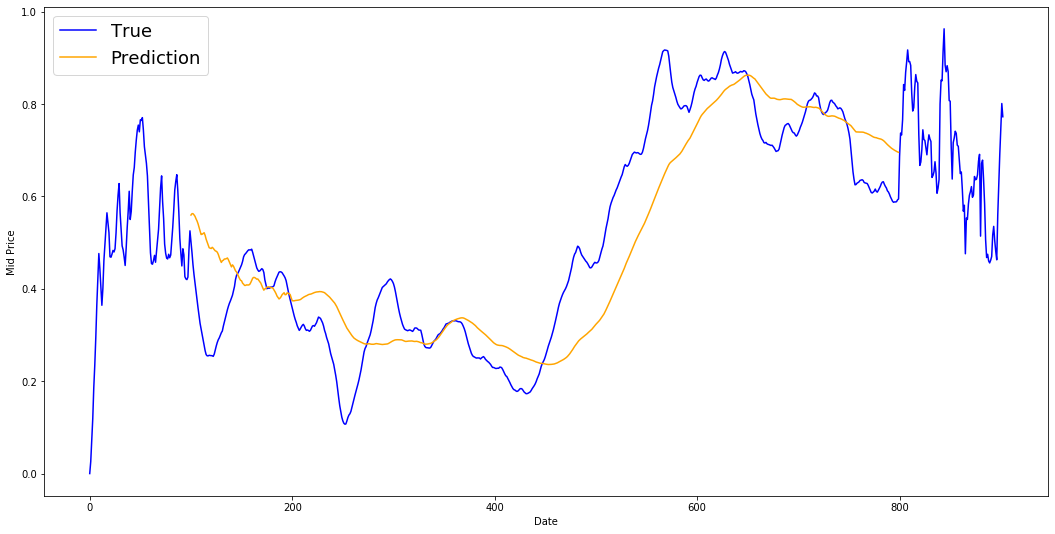

In [18]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [19]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

mse_test_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[0,pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[0,pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

for pred_idx in range(800,903):

    running_mean = running_mean*decay + (1.0-decay)*run_avg_predictions[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_test_errors.append((run_avg_predictions[-1]-test_data[pred_idx - 800])**2)
    run_avg_x.append(date) 
    

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_test_errors)))


MSE error for EMA averaging: 0.00650
MSE error for EMA averaging: 0.01135


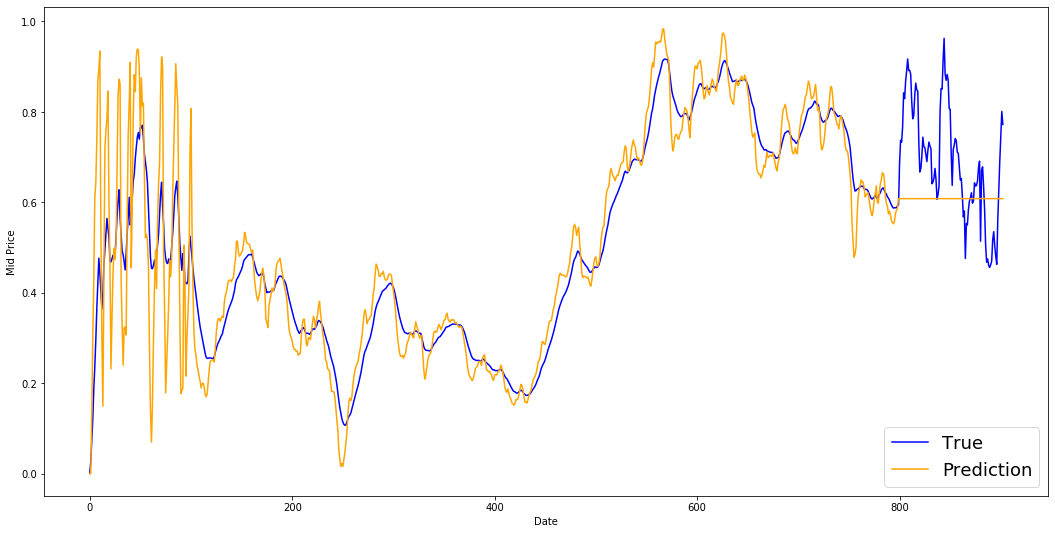

In [20]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,903),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()



In [21]:
len(all_mid_data)

903

## LSTM

In [22]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


Using TensorFlow backend.


In [23]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [24]:
# First calculate the mid prices from the highest and lowest
high_prices = df["High"]
low_prices = df["Low"]
df["mid_prices"] = (high_prices+low_prices)/2.0


In [25]:
def scale_df(values):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaler,scaled

def reframe_df(df):
    # frame as supervised learning
    reframed = series_to_supervised(df, 1, 1)

    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
    return reframed

def train_test_split(values, limit):
    # split into train and test sets
    train = values[:limit, :]
    test = values[limit:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    return train_X, train_y, test_X, test_y

def reshape_features(train_X, test_X):
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, test_X

def plot_history(history):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var6(t)
1   0.000000   0.007194        0.0        0.0   0.002074   0.000000  0.046342
2   0.000000   0.007194        0.0        0.0   0.002333   0.046342  0.083634
3   0.076923   0.000000        0.0        0.0   0.002074   0.083634  0.099383
4   0.000000   0.014388        0.0        0.0   0.002593   0.099383  0.140280
5   0.076923   0.014388        0.0        0.0   0.002593   0.140280  0.120897
(800, 1, 6) (800,) (102, 1, 6) (102,)


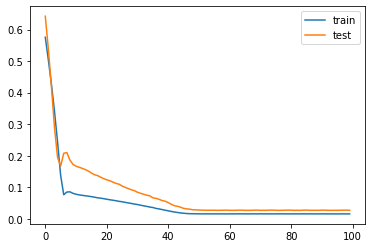

Test RMSE: 12.991


In [26]:
# Get the columns we need
df = df.sort_values('Date')
main_df = df[['sell','buy','calls','puts','score','mid_prices']]
#holder = main_df[-11:]
#main_df = main_df[:-10]
values = main_df.values


# ensure all data is float
values = values.astype('float32')

# normalize features
scaler, scaled = scale_df(values)
#frame as supervised learning
reframed = reframe_df(scaled)

print(reframed.head())

# Train Test Split
train_X, train_y, test_X, test_y = train_test_split(reframed.values, 800)

# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_features(train_X, test_X)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)


# plot history
plot_history(history)
    
# make a prediction
tests = test_y.reshape((len(test_y), 1))
test = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#display(concatenate((test[:, 1:],tests), axis=1))
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, 1:],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,5]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 1:],test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,5]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('Test RMSE: %.3f' % rmse)

Text(0, 0.5, 'Stock MidPrices')

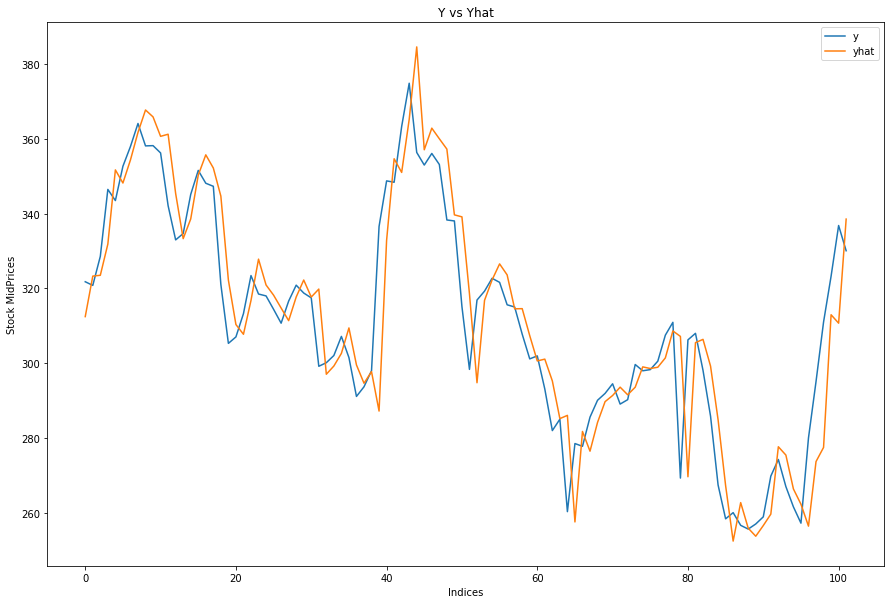

In [27]:
pd.DataFrame(data = {'y':inv_y, 'yhat': inv_yhat}).plot(figsize=(15,10))
plt.title("Y vs Yhat")
plt.xlabel("Indices")
plt.ylabel("Stock MidPrices")

In [28]:
"""
def reframe_df(df):
    # frame as supervised learning
    reframed = series_to_supervised(df, 1, 1)

    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
    return reframed

def train_test_split(values, limit):
    # split into train and test sets
    train = values[:limit, :]
    test = values[limit:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    return train_X, train_y, test_X, test_y
"""

def reframe_df(df):
    # frame as supervised learning
    reframed = series_to_supervised(df, 1, 1)

    # drop columns we don't want to predict
    #reframed.drop(reframed.columns, axis=1, inplace=True)
    return reframed

def train_test_split(values, limit):
    # split into train and test sets
    train = values[:limit, :]
    test = values[limit:, :]
    # split into input and outputs
    train_X, train_y = train[:, :6], train[:, 6:]
    test_X, test_y = test[:, :6], test[:, 6:]
    return train_X, train_y, test_X, test_y


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.000000   0.007194        0.0        0.0   0.002074   0.000000  0.000000   
2   0.000000   0.007194        0.0        0.0   0.002333   0.046342  0.076923   
3   0.076923   0.000000        0.0        0.0   0.002074   0.083634  0.000000   
4   0.000000   0.014388        0.0        0.0   0.002593   0.099383  0.076923   
5   0.076923   0.014388        0.0        0.0   0.002593   0.140280  0.000000   

    var2(t)  var3(t)  var4(t)   var5(t)   var6(t)  
1  0.007194      0.0      0.0  0.002333  0.046342  
2  0.000000      0.0      0.0  0.002074  0.083634  
3  0.014388      0.0      0.0  0.002593  0.099383  
4  0.014388      0.0      0.0  0.002593  0.140280  
5  0.028777      0.0      0.0  0.002593  0.120897  
(800, 1, 6) (800, 6) (102, 1, 6) (102, 6)


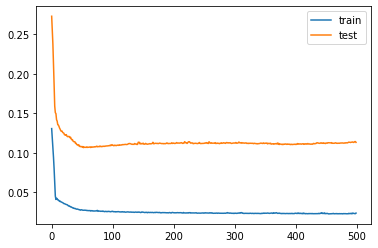

Test RMSE: 262.655


In [29]:
# Get the columns we need
df = df.sort_values('Date')
main_df = df[['sell','buy','calls','puts','score','mid_prices']]
#holder = main_df[-11:]
#main_df = main_df[:-10]
values = main_df.values


# ensure all data is float
values = values.astype('float32')

# normalize features
scaler, scaled = scale_df(values)
#frame as supervised learning
reframed = reframe_df(scaled)

print(reframed.head())

# Train Test Split
train_X, train_y, test_X, test_y = train_test_split(reframed.values, 800)

# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_features(train_X, test_X)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1]))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)


# plot history
plot_history(history)
    
# make a prediction
tests = test_y.reshape((len(test_y), train_y.shape[1]))
test = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#display(concatenate((test[:, 1:],tests), axis=1))
yhat = model.predict(test_X)

inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))

print('Test RMSE: %.3f' % rmse)

In [30]:
def scale_df(values):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaler, scaled

def reframe_df(df):
    # frame as supervised learning
    reframed = series_to_supervised(df, 1, 1)

    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
    return reframed

def train_test_split(values, limit):
    # split into train and test sets
    values = reframed.values
    limit = 800
    train = values[:limit, :]
    test = values[limit:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    return train_X, train_y, test_X, test_y

def reshape_features(train_X, test_X):
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, test_X

def plot_history(history):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

   var1(t-1)   var1(t)
1   0.000000  0.046342
2   0.046342  0.083634
3   0.083634  0.099383
4   0.099383  0.140280
5   0.140280  0.120897
(800, 1, 1) (800,) (102, 1, 1) (102,)
Train on 800 samples, validate on 102 samples
Epoch 1/100
 - 0s - loss: 0.6112 - val_loss: 0.7335
Epoch 2/100
 - 0s - loss: 0.5580 - val_loss: 0.6747
Epoch 3/100
 - 0s - loss: 0.5034 - val_loss: 0.6132
Epoch 4/100
 - 0s - loss: 0.4454 - val_loss: 0.5468
Epoch 5/100
 - 0s - loss: 0.3827 - val_loss: 0.4740
Epoch 6/100
 - 0s - loss: 0.3143 - val_loss: 0.3935
Epoch 7/100
 - 0s - loss: 0.2393 - val_loss: 0.3043
Epoch 8/100
 - 0s - loss: 0.1595 - val_loss: 0.2072
Epoch 9/100
 - 0s - loss: 0.0986 - val_loss: 0.1261
Epoch 10/100
 - 0s - loss: 0.0871 - val_loss: 0.0871
Epoch 11/100
 - 0s - loss: 0.0924 - val_loss: 0.0776
Epoch 12/100
 - 0s - loss: 0.0939 - val_loss: 0.0773
Epoch 13/100
 - 0s - loss: 0.0927 - val_loss: 0.0793
Epoch 14/100
 - 0s - loss: 0.0909 - val_loss: 0.0812
Epoch 15/100
 - 0s - loss: 0.0889 - val_loss:

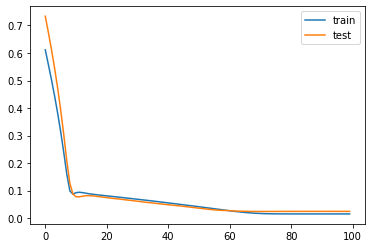

Test RMSE: 11.795


In [31]:
# Get the columns we need
df = df.sort_values('Date')
main_df = df[['mid_prices']]
values = main_df.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler, scaled = scale_df(values)
#frame as supervised learning
#reframed = reframe_df(scaled)
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

# Train Test Split
train_X, train_y, test_X, test_y = train_test_split(values, 800)

# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_features(train_X, test_X)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


# plot history
plot_history(history)
    
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, 1:],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 1:],test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('Test RMSE: %.3f' % rmse)